In [1]:
import pandas as pd
import numpy as np

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Data

In [2]:
df = pd.read_csv('data/data1.csv')
df = df.set_index('Date').rename_axis('Adj. Close', axis=1)

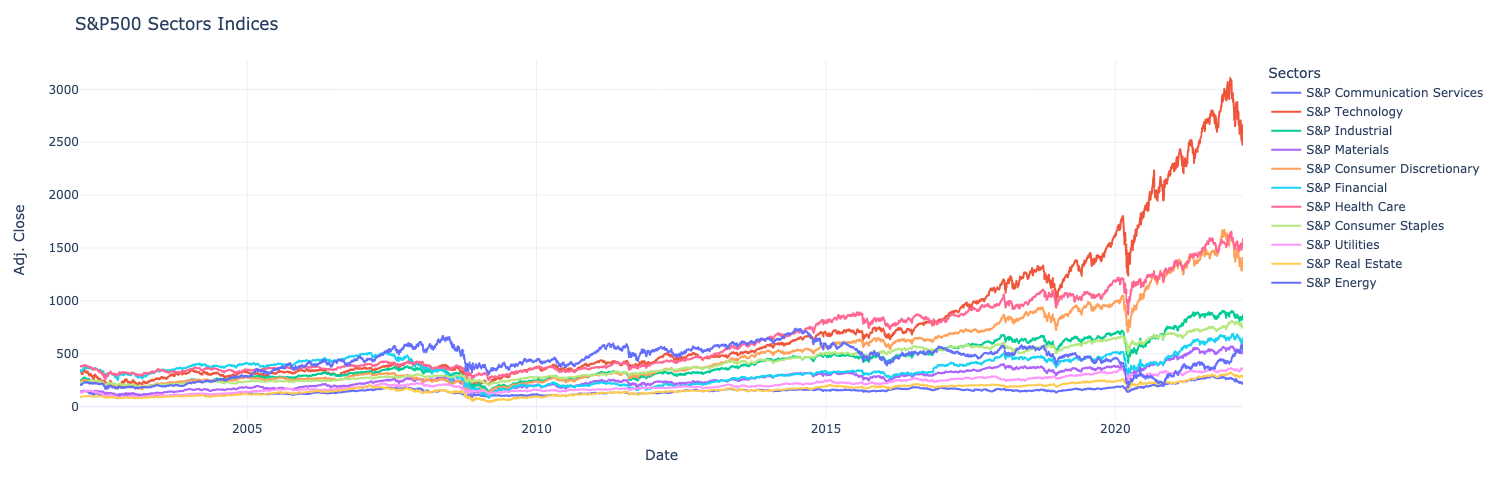

In [3]:
px.line(df).update_layout(
    yaxis_title='Adj. Close', legend_title='Sectors',
    title='S&P500 Sectors Indices'
)

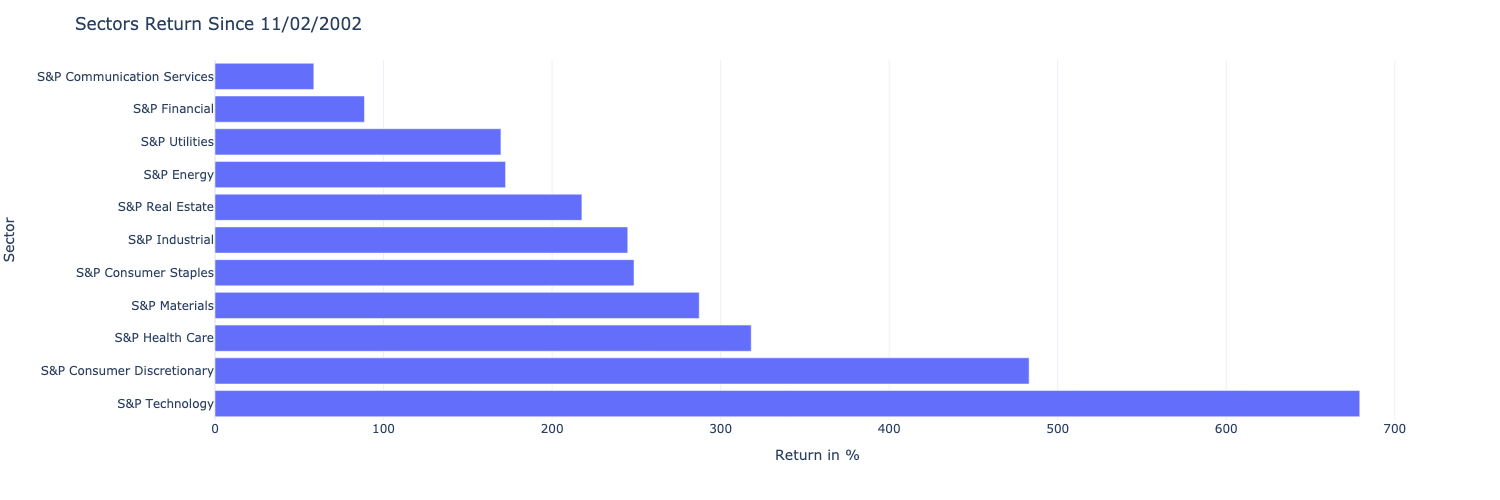

In [4]:
px.bar(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0], orientation='h').update_layout(
    showlegend=False, yaxis={'categoryorder':'total descending'},
    xaxis_title='Return in %', yaxis_title='Sector',
    title='Sectors Return Since 11/02/2002'
)

# Stationarity : Log Daily Losses
Clearly we don't have stationarity in the Adj. Close time series so we transform them into the log daily losses as suggested by different references. We suppose we have stationarity for now.

In [5]:
ll = -100*(np.log(df)-np.log(df.shift(1)))
ll = ll.iloc[1:]
ll = ll.rename_axis('Loss', axis=1)

ll.describe()

Loss,S&P Communication Services,S&P Technology,S&P Industrial,S&P Materials,S&P Consumer Discretionary,S&P Financial,S&P Health Care,S&P Consumer Staples,S&P Utilities,S&P Real Estate,S&P Energy
count,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000,5060.000000
mean,-0.009119,-0.040575,-0.024468,-0.026760,-0.034843,-0.012547,-0.028274,-0.024679,-0.019604,-0.022843,-0.019804
std,1.375972,1.512763,1.357793,1.523733,1.359066,1.912293,1.108438,0.916661,1.239975,1.934860,1.817573
min,-12.926144,-11.461005,-12.000787,-12.472998,-12.313148,-17.201298,-11.713084,-8.835281,-12.683954,-18.851048,-16.960375
25%,-0.658809,-0.750099,-0.662297,-0.810896,-0.685611,-0.733758,-0.577287,-0.471657,-0.631993,-0.740688,-0.902953
50%,-0.043729,-0.088375,-0.076475,-0.078717,-0.086960,-0.047692,-0.057076,-0.046680,-0.080314,-0.072551,-0.058152
75%,0.603238,0.615360,0.548167,0.673559,0.550524,0.657879,0.465612,0.393229,0.532638,0.640919,0.800500
max,11.030052,14.983342,12.154999,12.933856,12.877171,18.638980,10.527413,9.690027,12.265320,20.422691,22.417196


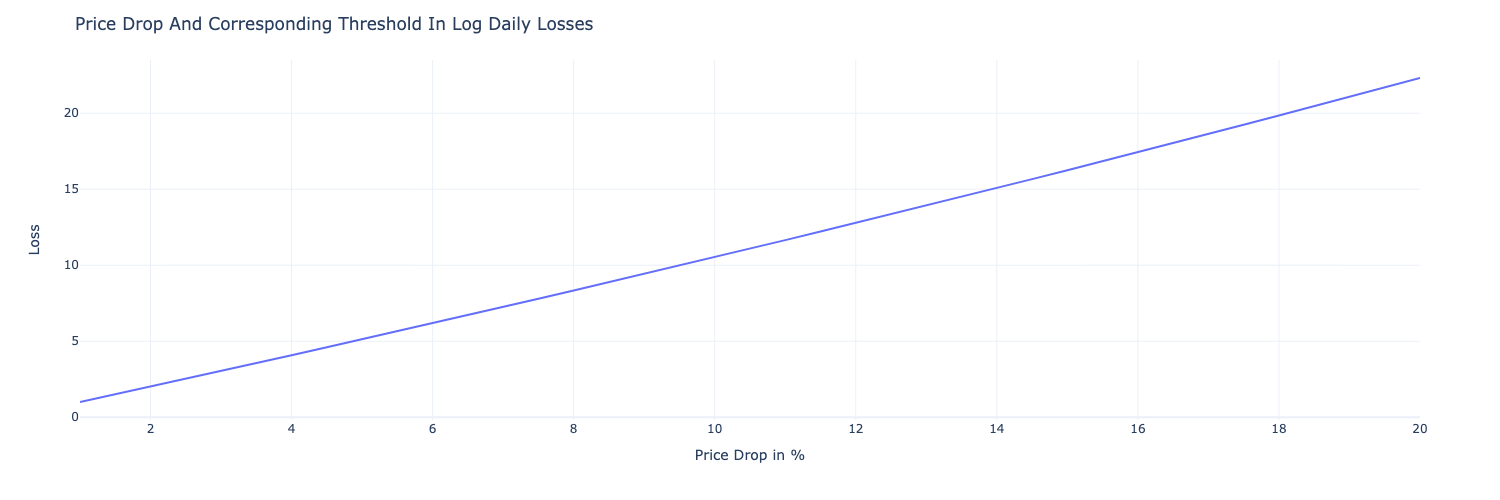

In [6]:
p_drops = np.arange(1,20.5,0.5)
ll_p = [-100*np.log(1-x/100) for x in p_drops]

px.line(x=p_drops, y=ll_p).update_layout(
    xaxis_title='Price Drop in %', yaxis_title='Loss',
    title='Price Drop And Corresponding Threshold In Log Daily Losses'
)

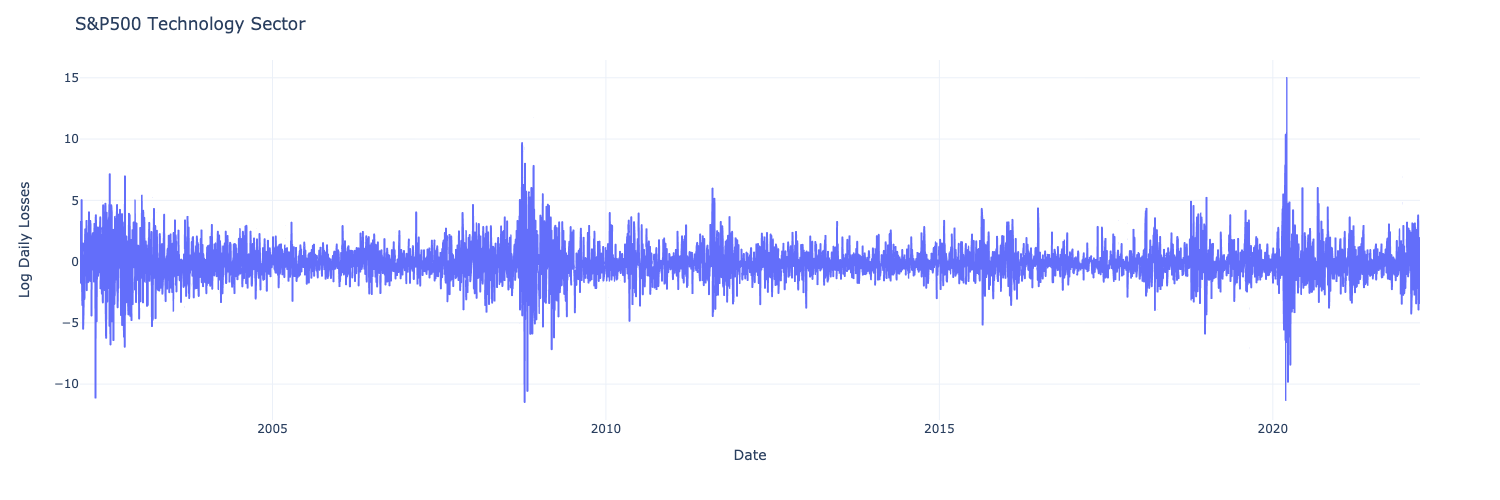

In [7]:
px.line(ll.iloc[:,1]).update_layout(
    showlegend=False, yaxis_title='Log Daily Losses',
    title='S&P500 Technology Sector'
)

# Exploratory Data Analysis
For simplicity, we denote the Log Daily Losses by loss.

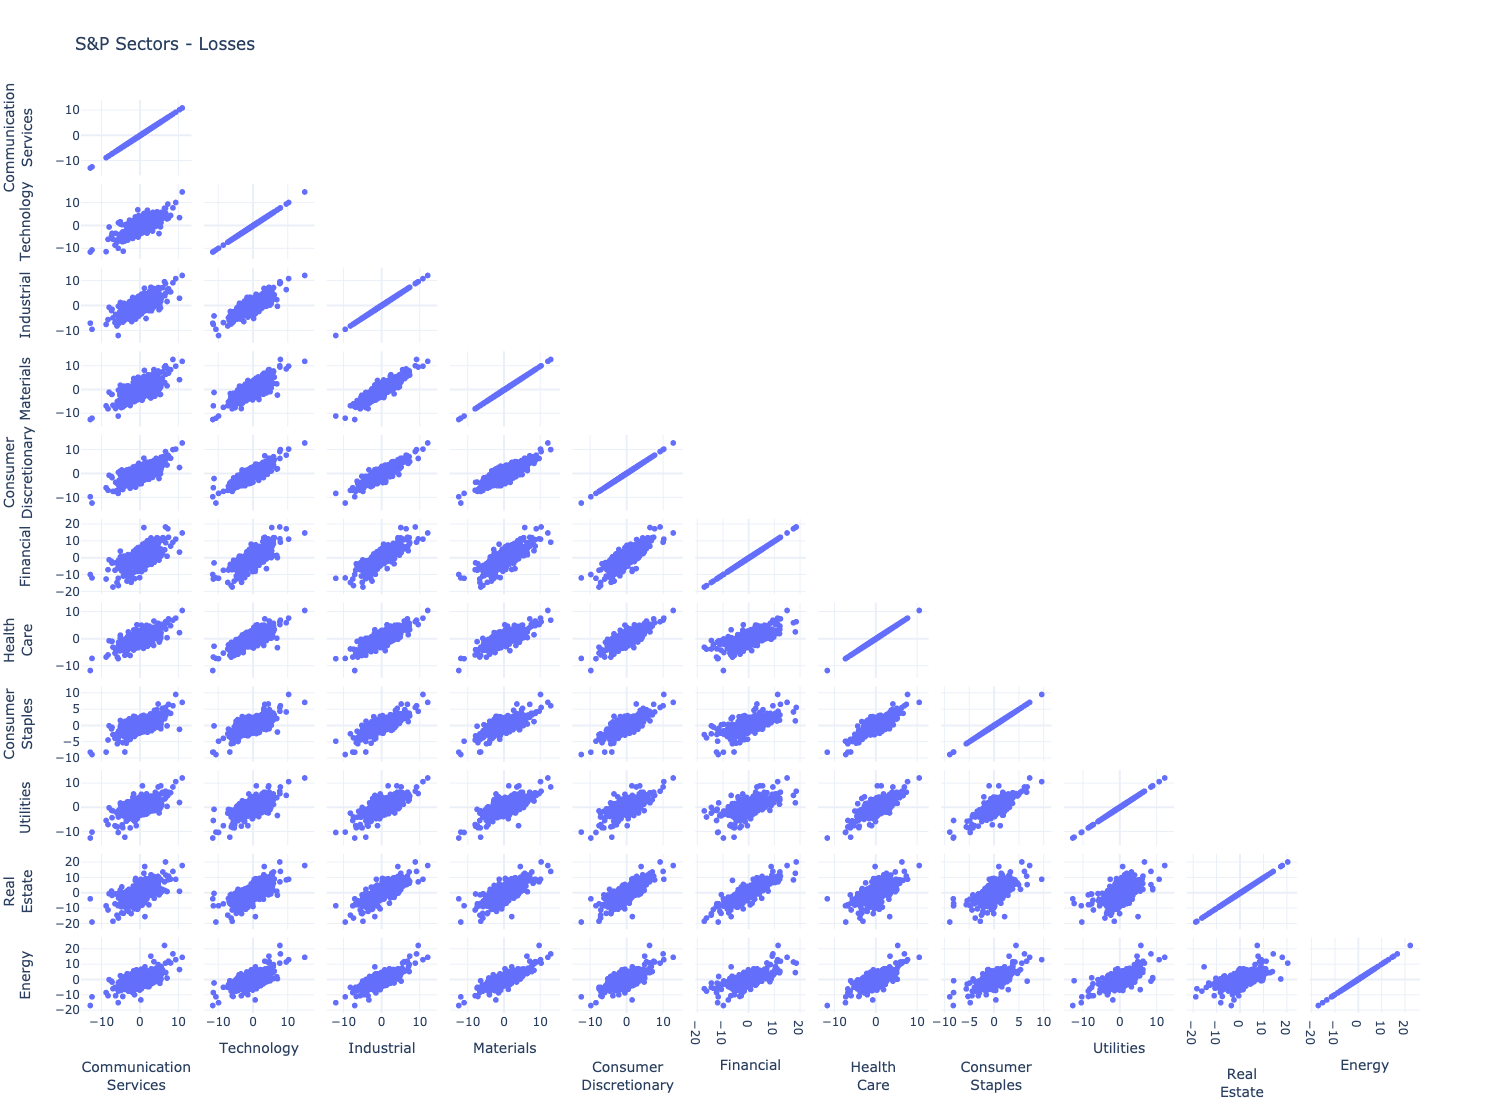

In [8]:
fig = go.Figure(
    data=go.Splom(
        dimensions=[dict(label=s[4:].replace(' ','<br>'), values=ll[s]) for s in ll.columns.values],
        showupperhalf=False
    )
).update_layout(
    title='S&P Sectors - Losses',
    width=1500, height=1100
)

fig.show()

Clearly, the shape of the extremes (high losses) is different depending on the pair of sectors.

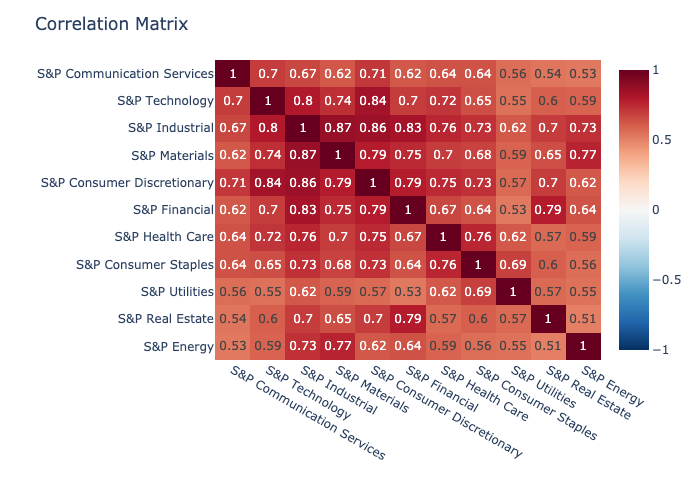

In [9]:
px.imshow(ll.corr().round(2), color_continuous_scale='RdBu_r', range_color=[-1,1], text_auto=True, aspect='auto').update_layout(
    title='Correlation Matrix',
    xaxis_title='', yaxis_title='',
    width=700
)

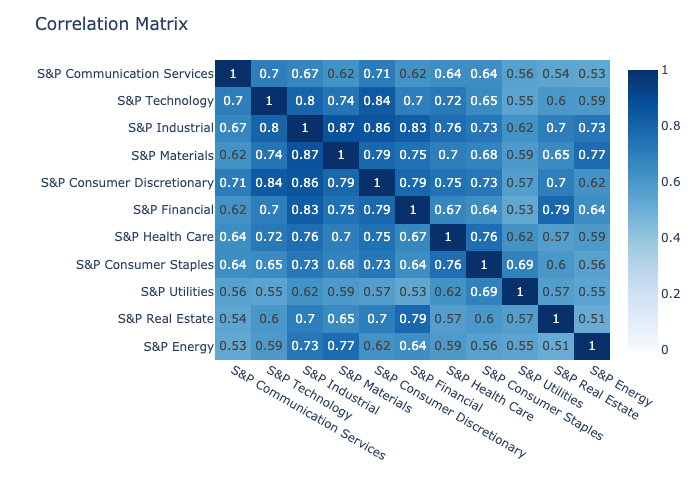

In [10]:
px.imshow(ll.corr().round(2), color_continuous_scale='Blues', range_color=[0,1], text_auto=True, aspect='auto').update_layout(
    title='Correlation Matrix',
    xaxis_title='', yaxis_title='',
    width=700
)

There is a positive correlation between the sectors which is expected. One the pairs that seems interesting in terms of asymptotic dependence are the technology and energy, real estate, utilities. First, the correlation is the smallest. Second, based on current events, February 2022, where the S&P500 is struggling and the energy sectors is out performing during a high volatility period and corrections.

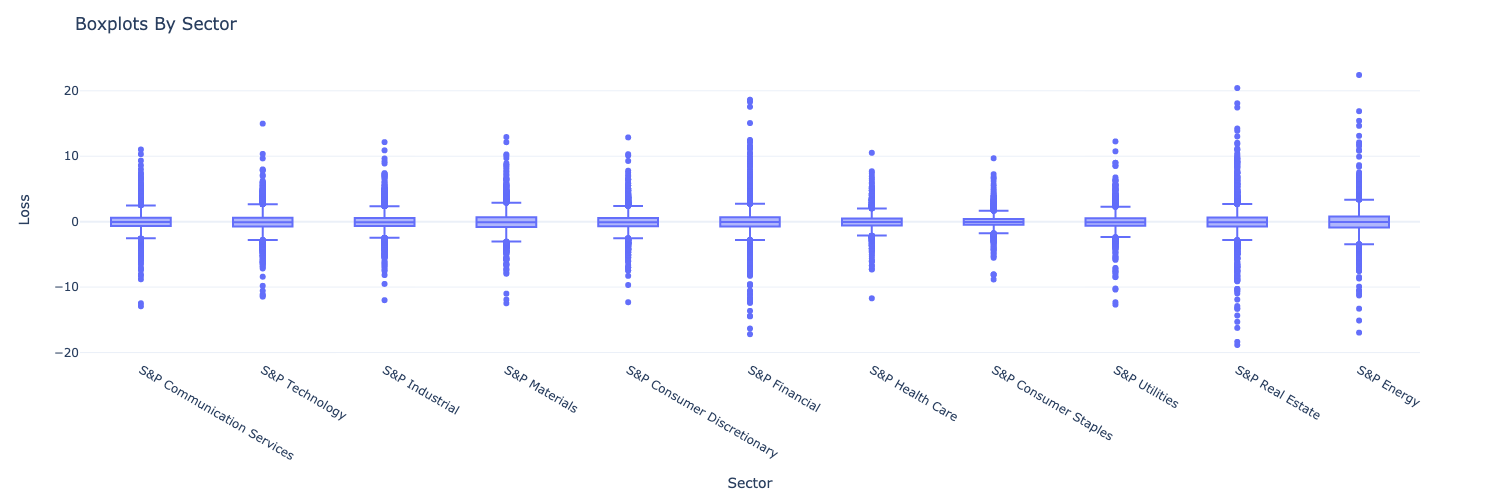

In [11]:
px.box(ll).update_layout(
    xaxis_title='Sector', yaxis_title='Loss',
    title='Boxplots By Sector'
)

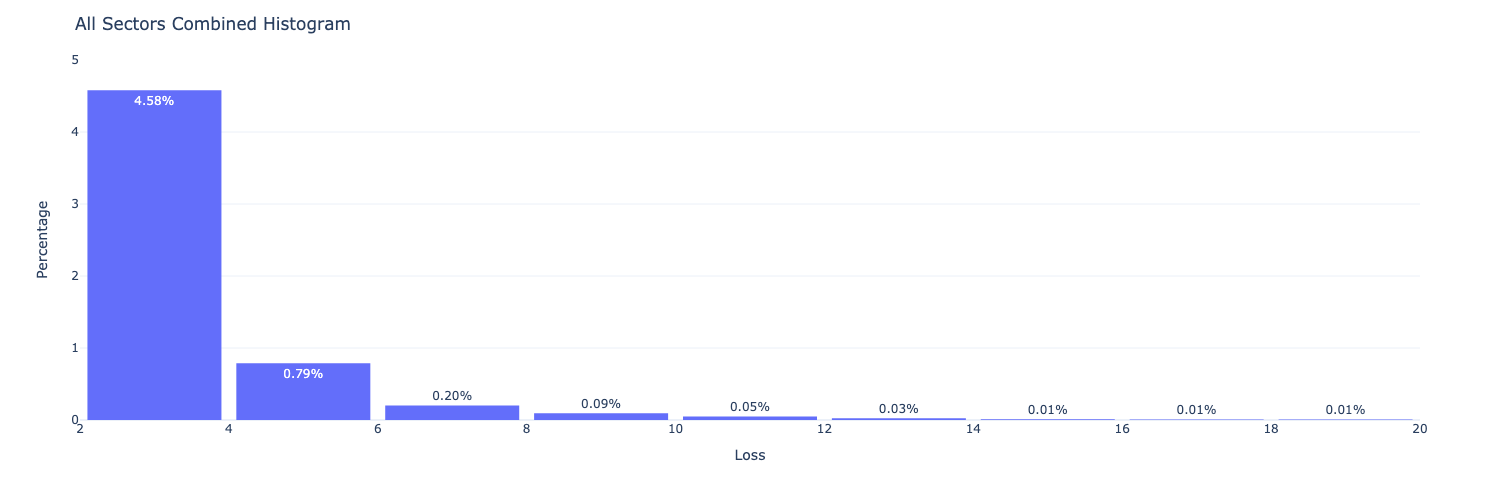

In [12]:
px.histogram(x=ll.values.reshape(-1), histnorm='percent', cumulative=False, nbins=30, text_auto=True).update_layout(
    xaxis_title='Loss', yaxis_title='Percentage',
    title='All Sectors Combined Histogram',
    showlegend=False, bargap=0.1
).update_traces(texttemplate='%{y:.2f}%').update_xaxes(range=(2,20)).update_yaxes(range=(0,5))

A threshold of 5% seems too high (not enough observations - exceedances) however 2% seems appropriate.

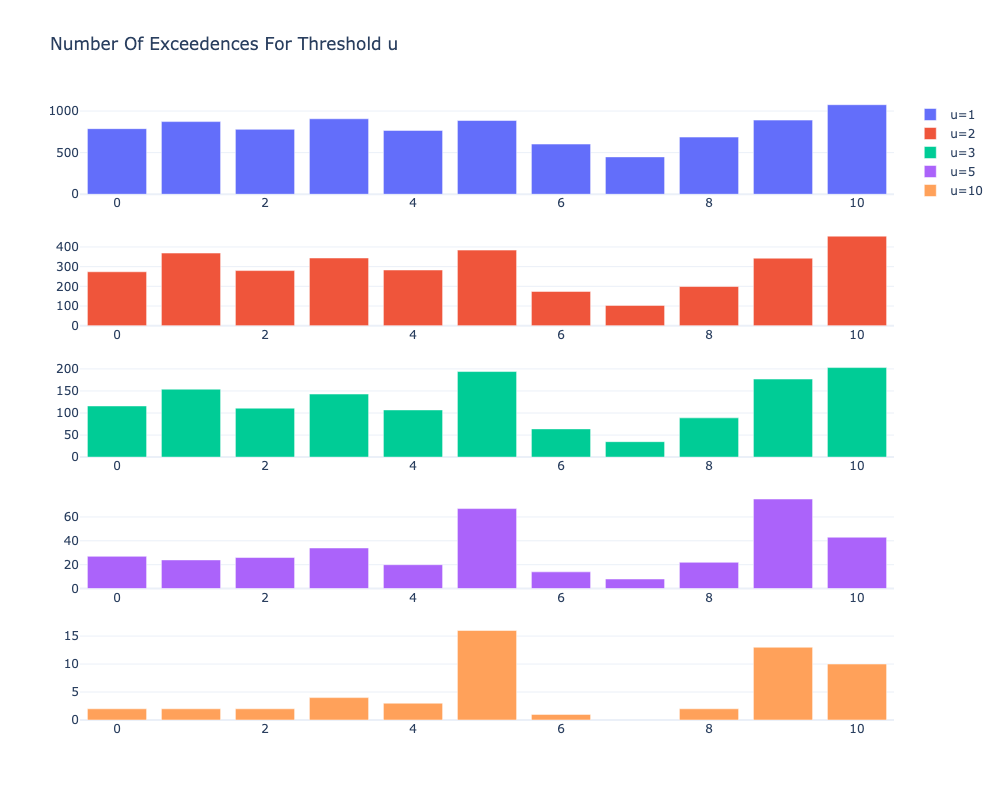

In [13]:
fig = make_subplots(rows=5, cols=1)

for i,u in enumerate([1,2,3,5,10]):
    fig.add_trace(
        go.Bar(y=(ll>u).apply(lambda x: x.value_counts()).iloc[1], name='u='+str(u)),
        row=i+1, col=1
    )
    
fig.update_layout(
    title='Number Of Exceedences For Threshold u',
    height=800, width=1000
)

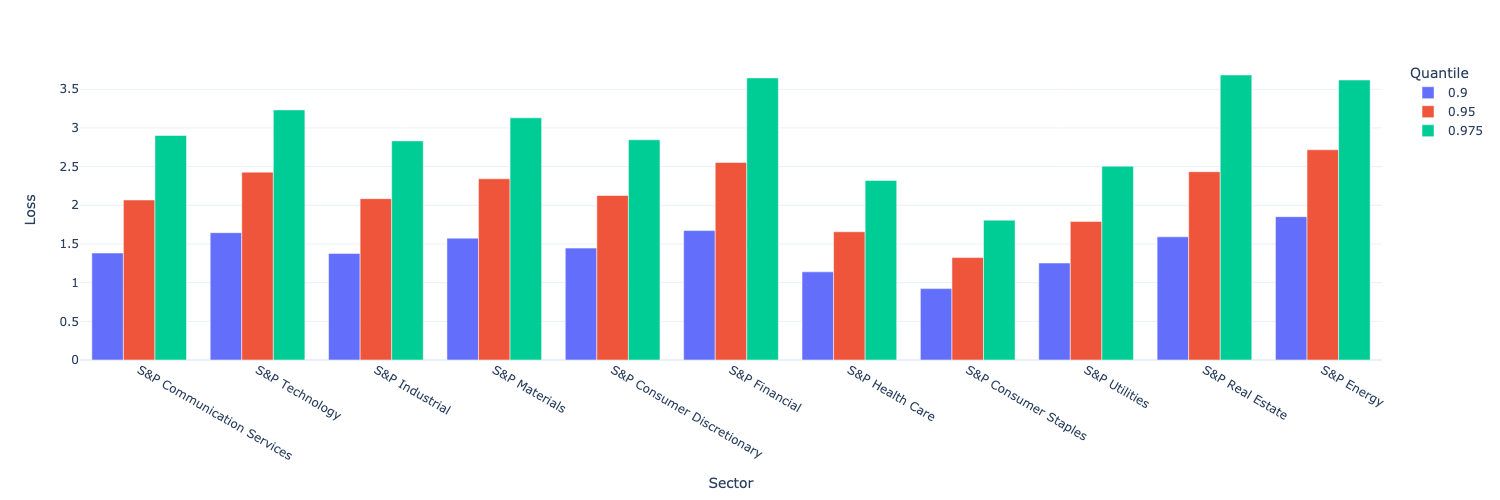

In [14]:
px.bar(ll.quantile([0.9,0.95,0.975]).T, barmode='group').update_layout(
    legend_title='Quantile',
    yaxis_title='Loss',
    xaxis_title='Sector'
)

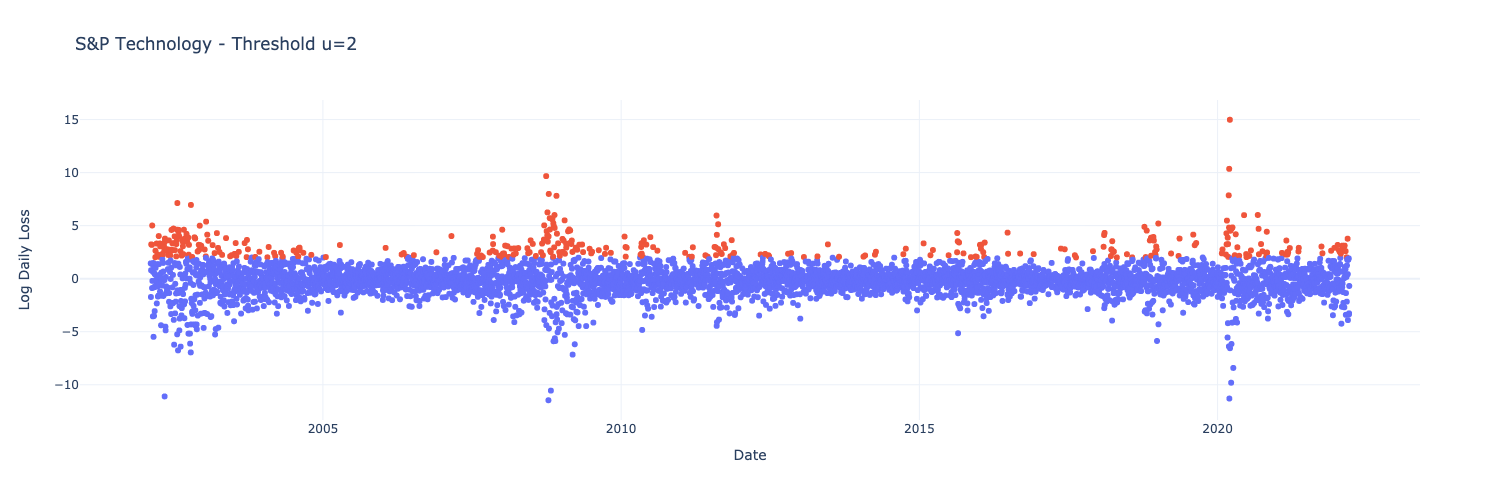

In [15]:
ts = ll.iloc[:,1]
u = 2

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ts.index, y=ts.values, mode='markers', marker_color=['#EF553B' if x>u else '#636EFA' for x in ts.values]
))

fig.update_layout(
    title=ts.name+' - Threshold u='+str(u),
    xaxis_title='Date', yaxis_title='Log Daily Loss',
    height=500, width=1500
)

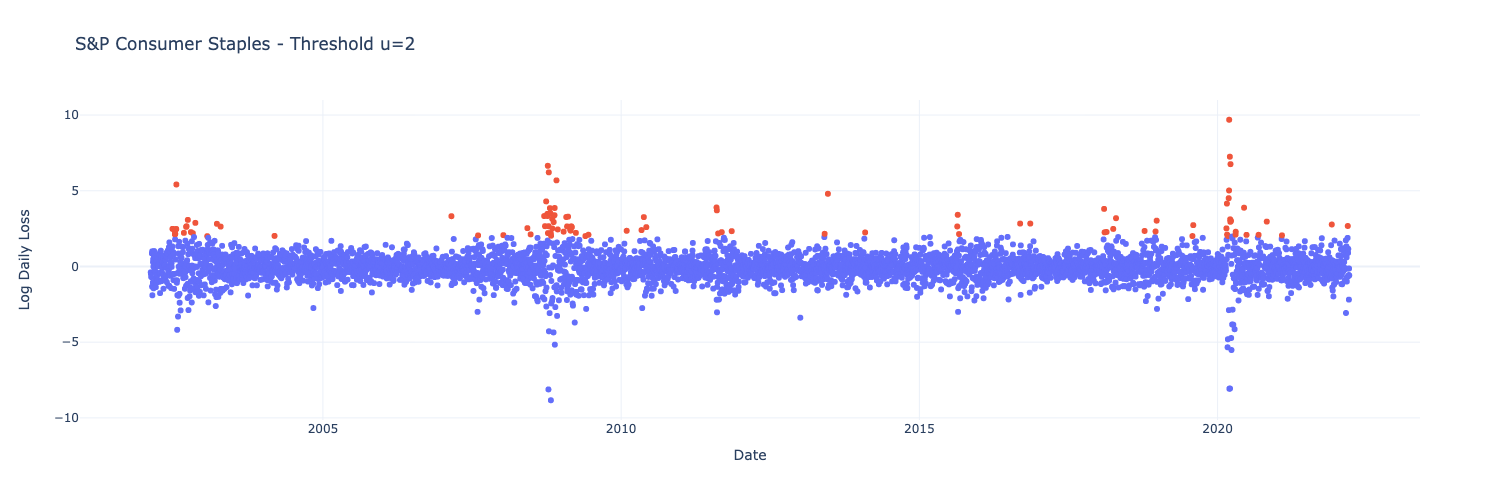

In [16]:
ts = ll.iloc[:,7]
u = 2

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ts.index, y=ts.values, mode='markers', marker_color=['#EF553B' if x>u else '#636EFA' for x in ts.values]
))

fig.update_layout(
    title=ts.name+' - Threshold u='+str(u),
    xaxis_title='Date', yaxis_title='Log Daily Loss',
    height=500, width=1500
)

# Empirical Estimate Of Asymptotic Dependence

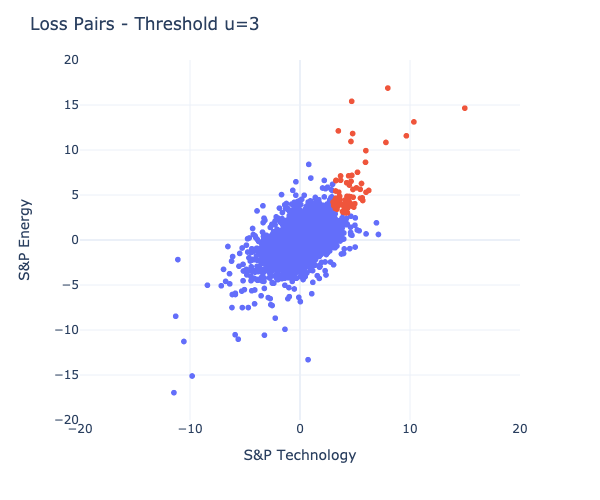

In [17]:
ts1 = ll.iloc[:,1]
ts2 = ll.iloc[:,10]

u = 3
color = ['#EF553B' if (ts1[i]>u)&(ts2[i]>u) else '#636EFA' for i in range(len(ts1))]

px.scatter(x=ts1, y=ts2, color=color).update_layout(
    title='Loss Pairs - Threshold u='+str(u),
    xaxis_title=ts1.name, yaxis_title=ts2.name,
    xaxis_range=(-20,20), yaxis_range=(-20,20),
    height=500, width=600, showlegend=False
)

In [16]:
def get_chi(ts1,ts2):
    
    n = len(ts1)
    q_range = np.arange(0.01,1,0.01)

    chi = []
    chib = []

    for q in q_range:

        fu, fd, chiu, chid = 0,0,0,0

        for i in range(n):

            fxi = ((ts1<=ts1[i]).sum()-1)/(n-1)
            fyi = ((ts2<=ts2[i]).sum()-1)/(n-1)

            fu += int((fxi<q) and (fyi<q))
            fd += 1-int((fxi<q) or (fyi<q))

        chiu = 2-np.log(fu/n)/np.log(q)
        chi.append(chiu)

        chid = 2*np.log(1-q)/np.log(fd/n)-1
        chib.append(chid)
        
    return q_range, chi, chib

In [17]:
def plot_chi(ts1,ts2):
    
    q_range, chi, chib = get_chi(ts1,ts2)

    fig = make_subplots(rows=1, cols=2, subplot_titles=['Chi','Chi Bar'])

    fig.add_trace(
        go.Scatter(x=q_range, y=chi),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=q_range, y=chib),
        row=1, col=2
    )

    if 0:
        fig.add_trace(
            go.Scatter(x=q_range, y=chil, line_color='grey', line_dash='dash'),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chih, line_color='grey', line_dash='dash'),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chibl, line_color='grey', line_dash='dash'),
            row=1, col=2
        )

        fig.add_trace(
            go.Scatter(x=q_range, y=chibh, line_color='grey', line_dash='dash'),
            row=1, col=2
        )

    fig.update_xaxes(title_text='q')
    fig.update_yaxes(title_text=r'$\chi(q)$', range=[0,1], row=1, col=1)
    fig.update_yaxes(title_text=r'$\bar{\chi}(q)$', range=[-1,1], row=1, col=2)

    fig.update_layout(
        title_text='Empirical Estimate Of Asymptotic Dependence : '+ts1.name+' / '+ts2.name,
        showlegend=False,
        height=600, width=1200
    )

    return fig

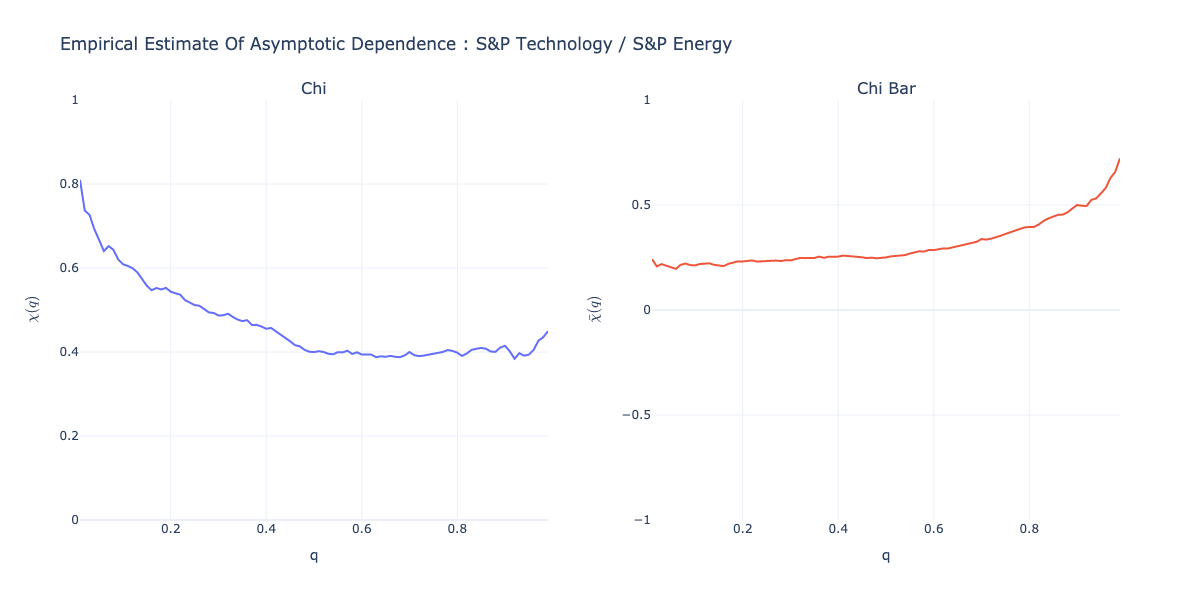

In [18]:
plot_chi(ts1,ts2)

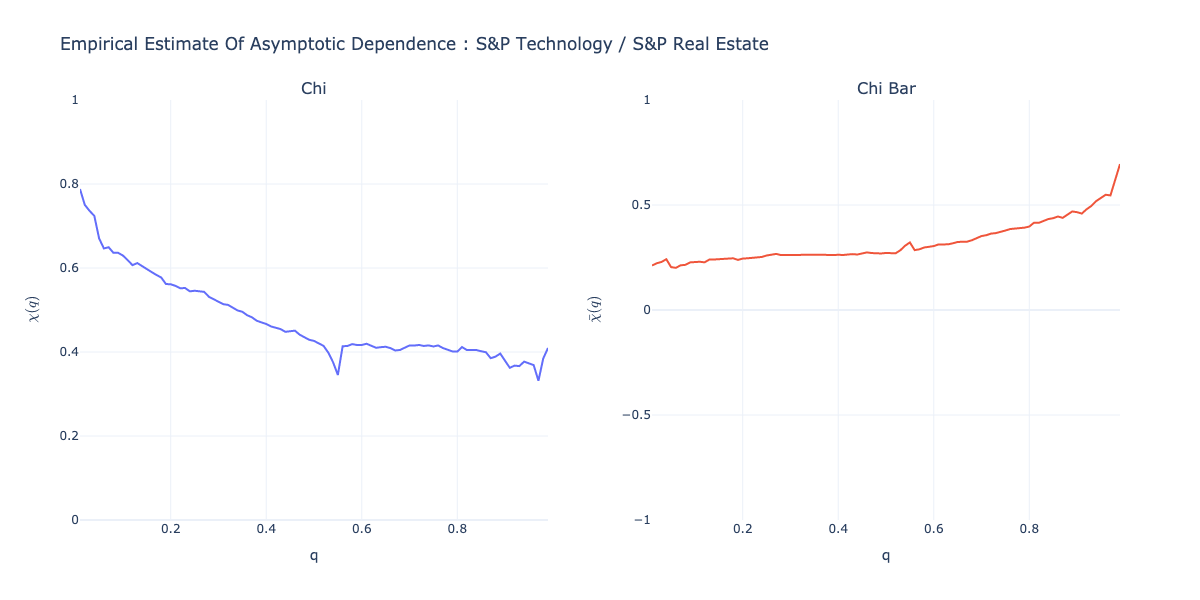

In [19]:
plot_chi(ts1,ll.iloc[:,9])

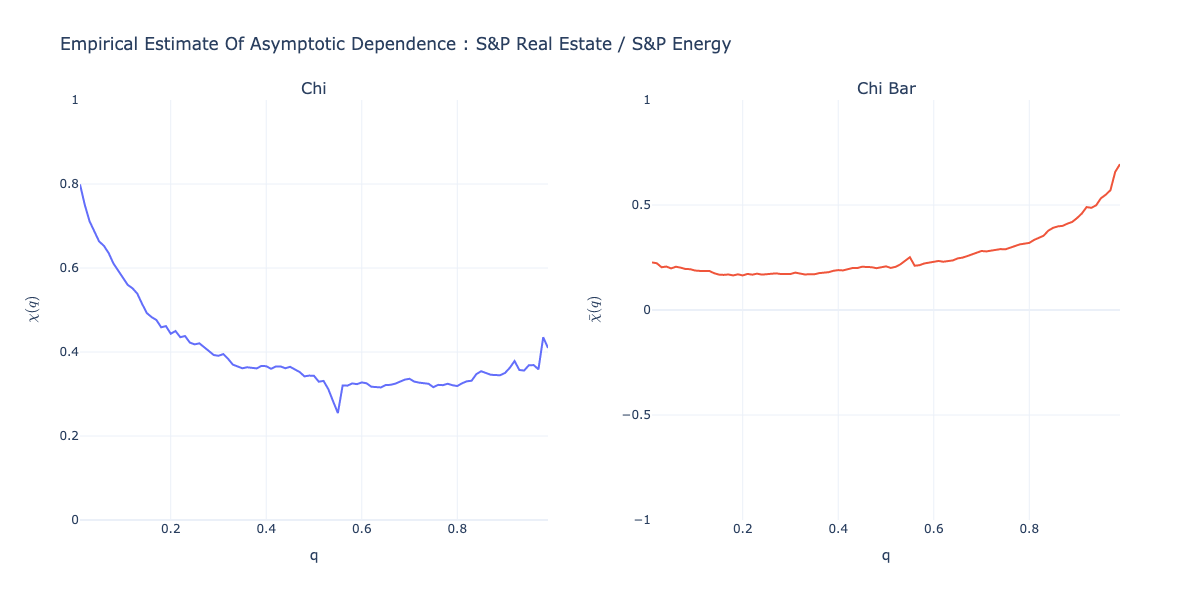

In [20]:
plot_chi(ll.iloc[:,9],ts2)